#### WORD COUND: 1900
## SAMSON ALABI ORODELE
### W22018376

## Classification of Breast Cancer Images

### Introduction

Breast cancer is a type of tumour that develops in the breat cells and is one of the prevalent causes of death in women (Wang et al, 2022; Amin et al., 2022; Chaudury). The development of computer vision and machine learning have helped the reliability of classification of histology images, which can be advantageous in the early detection of breast cancer(Vo, 2019).
This study will focus on the classification of histology images into Invasive ductal Carcinoma(IDC) or non-IDC. The dataset used for this study contains 5547 breast histology images with a size of 50 x50 x3.
Six machine learning models will be explored in this classification task. These contain three variants of Convolutional Neural Networks(CNN), a Multilayer Perceptron(MLP), which is a type of Artificial Neural Network(ANN), a pretrained model(MobileNetV2) and a classical supervised model(Support Vector Machine – SVM.)

The performance of these algorithms will be compared to determine the best performing algorithms suited for detecting IDC from histology images. The outcome of this investigation has a high likelihood of influencing early detection of breast cancer which will invariably translate into early treatment.

### Literature Review

 Quite a number of studies have been conducted on breast cancer detection using deep learning models such as CNN, ANN and pre-trained models like VGG-16.
Samriddha et al. (2023) used an ensemble of three standard CNN models namely GoogleNet, VGG11 and MobileNet V3 which yielded a very impressive accuracy of 96.95%. ConvNet C obtained an accuracy of 88.7% and a sensitivity of 92.6% when Guptal et al(2022) classified a hundred thousand histology images.


### Preparing the Tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D,Input,Dropout
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from tensorflow import image
from keras.optimizers import Adam

from skimage.transform import resize

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import random
from keras.layers import BatchNormalization
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold

# Setting seed For reproducibility
seed = 42
np.random.seed(seed)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from kerastuner.tuners import RandomSearch #For tuning hyperparameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image augmentation


**Data**

The data utilised in this study is a publicly available dataset downloaded from Kaggle.

#### Importing the Dataset

In [ ]:
# This loads the data
x_input = np.load('X.npy')
y_target= np.load('Y.npy')

### Exploratory Data Analysis
To gain some understanding and insight on the data of the data, some exploratory analysis were performed. This dataset contains 5547 breast histology images with each having a dimension of 50 by 50 by 3(rows, columns, RGB channels). The dataset can be considered to have a balanced class as 2759 negative images and 2788 positive images were present. A glimpse was taken as to how the images looked like by plotting five random positive images and five random negative images. Investigation was also made to determine the intensity range, colour distribution and contrast of the images.

***Rationale and Objective of Study***:
This study is an object recogintion task which will focus on investigating machine learning models that can be suitable to successfully classify IDC cases as either positive or negative based on the presence of some characteristic features in the images.

In [ ]:
#To determine the dimensions of the data
print('x_input dimension= {}'.format(x_input.shape))
print('y_labels dimension= {}'.format(y_target.shape))

x_input dimension= (5547, 50, 50, 3)
y_labels dimension= (5547,)


In [ ]:
#To further gain more insight on the data by checking the balance and statistics:
print('Total number of images= {}'.format(len(x_input)))
print('Quantity of Negative Images= {}'.format(np.sum(y_target==0)))
print('Quantity of Positive Images= {}'.format(np.sum(y_target==1)))
print('Percentage of positive images= {:.2f}%'.format(100*np.sum(y_target==1)/len(x_input)))
print('Percentage of Negative images= {:.2f}%'.format(100*np.sum(y_target==0)/len(x_input)))
print('Shape of one image(rows, columns, RGB channels)= {}'.format(x_input[22].shape))

Total number of images= 5547
Quantity of Negative Images= 2759
Quantity of Positive Images= 2788
Percentage of positive images= 50.26%
Percentage of Negative images= 49.74%
Shape of one image(rows, columns, RGB channels)= (50, 50, 3)


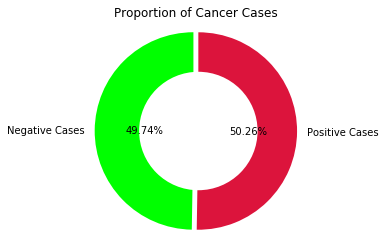

In [ ]:
# Checking if the data is balcanced by checking the proportion.

#To enumerate the number of cases
num_negative = np.sum(y_target == 0)
num_positive = np.sum(y_target == 1)

# Creating the pie chart for visualization
labels = ['Negative Cases', 'Positive Cases']
pie_sizes = [num_negative, num_positive]
colours = ['lime','crimson']
explode = (0.05, 0)

plt.pie(pie_sizes, labels=labels, colors = colours, explode=explode,
        autopct='%1.2f%%', startangle=90, pctdistance=0.5, labeldistance=1.1)

#To make it doughnut-like
centre_circle = plt.Circle((0,0),0.6,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# To  make pie drawn in a circle
plt.axis('equal')
plt.title('Proportion of Cancer Cases')
plt.show();

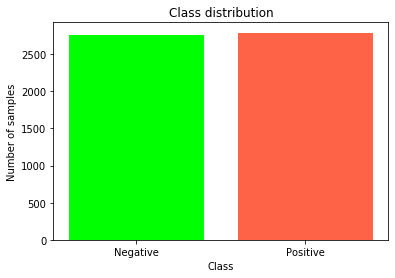

In [ ]:
# To get the number of samples in each of the classes
class_qty = np.bincount(y_target)

# Definining colors for each class
colors = ['lime', 'tomato']

# Making a bar chart
plt.bar(['Negative', 'Positive'], class_qty, color=colors)

# labels and title
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution');


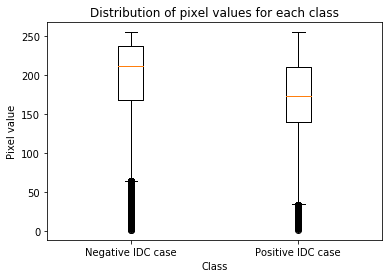

In [ ]:
# Boxplot to show the distribution of the pixel values
plt.boxplot([x_input[y_target==0],
             x_input[y_target==1]],
            labels=['Negative IDC case', 'Positive IDC case'])
plt.xlabel('Class')
plt.ylabel('Pixel value')
plt.title('Distribution of pixel values for each class');

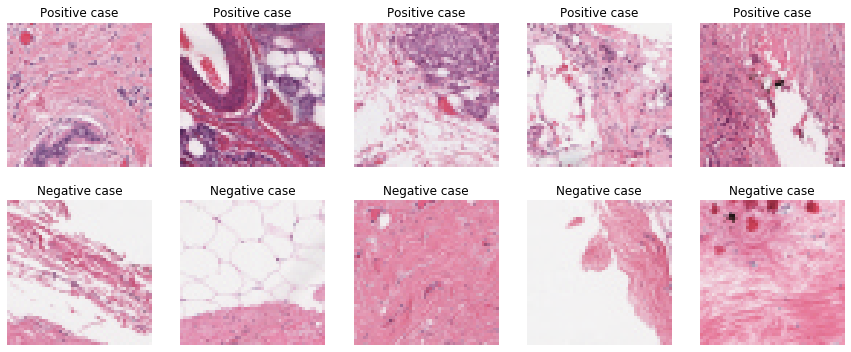

In [ ]:
#To view examples of a positive and a negative case

# To get 5 random positive images
positive_cases = x_input[y_target == 1]
positive_idx = random.sample(range(len(positive_cases)), 5)
positive_imgs = positive_cases[positive_idx]

# To get 5 random negative images
negative_cases = x_input[y_target == 0]
negative_indexes = random.sample(range(len(negative_cases)), 5)
negative_imgs = negative_cases[negative_indexes]


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, image in enumerate(positive_imgs):
    axes[0, i].imshow(image)
    axes[0, i].set_title('Positive case')
    axes[0, i].axis('off')

for i, image in enumerate(negative_imgs):
    axes[1, i].imshow(image)
    axes[1, i].set_title('Negative case')
    axes[1, i].axis('off');

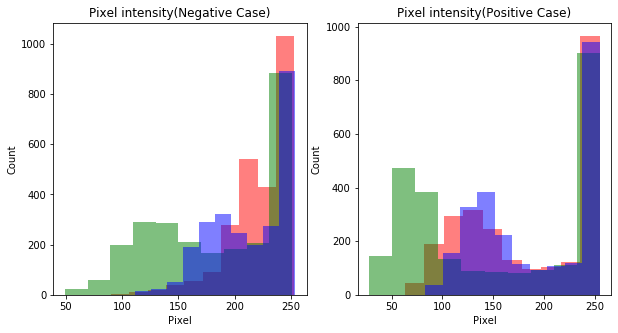

In [ ]:
# To determine the distribution of the pixel intensity in each class
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
imgs_0 = x_input[y_target == 0]
imgs_1 = x_input[y_target == 1]

#Pixel intensity for a negative case
axes[0].hist(imgs_0[1,:,:,0].flatten(), bins=10, lw=0, color='r', alpha=0.5);
axes[0].hist(imgs_0[1,:,:,1].flatten(), bins=10, lw=0, color='g', alpha=0.5);
axes[0].hist(imgs_0[1,:,:,2].flatten(), bins=10, lw=0, color='b', alpha=0.5);
axes[0].set_title('Pixel intensity(Negative Case)')
axes[0].set_xlabel('Pixel')
axes[0].set_ylabel('Count')

#Pixel intensity for positive case
axes[1].hist(imgs_1[1,:,:,0].flatten(), bins=10, lw=0, color='r', alpha=0.5);
axes[1].hist(imgs_1[1,:,:,1].flatten(), bins=10, lw=0, color='g', alpha=0.5);
axes[1].hist(imgs_1[1,:,:,2].flatten(), bins=10, lw=0, color='b', alpha=0.5);
axes[1].set_title('Pixel intensity(Positive Case)')
axes[1].set_xlabel('Pixel')
axes[1].set_ylabel('Count');

In [ ]:
#Statistical Propertis of all the Images

#To determine the statistical properties of RGB channels
mean_r, var_r, std_r = x_input[:,:,:,0].mean(), x_input[:,:,:,0].var(), x_input[:,:,:,0].std()
mean_g, var_g, std_g = x_input[:,:,:,1].mean(), x_input[:,:,:,1].var(), x_input[:,:,:,1].std()
mean_b, var_b, std_b = x_input[:,:,:,2].mean(), x_input[:,:,:,2].var(), x_input[:,:,:,2].std()

# To Print the RGB properties
print("Red channel - mean: ", round(mean_r,2), "  |variance: ", round(var_r,2), "|standard deviation: ", round(std_r,2))
print("Green channel - mean: ", round(mean_g,2), "|variance: ", round(var_g,2), "|standard deviation: ", round(std_g,2))
print("Blue channel - mean: ", round(mean_b,2), " |variance: ", round(var_b,2), "|standard deviation: ", round(std_b,2))

Red channel - mean:  205.79   |variance:  1317.28 |standard deviation:  36.29
Green channel - mean:  161.87 |variance:  2909.54 |standard deviation:  53.94
Blue channel - mean:  187.44  |variance:  1496.98 |standard deviation:  38.69


In [ ]:
#For the negative-case images

# To determine the statistical properties of RGB
mean_r, var_r, std_r = negative_cases[:,:,:,0].mean(), negative_cases[:,:,:,0].var(), negative_cases[:,:,:,0].std()
mean_g, var_g, std_g = negative_cases[:,:,:,1].mean(), negative_cases[:,:,:,1].var(), negative_cases[:,:,:,1].std()
mean_b, var_b, std_b = negative_cases[:,:,:,2].mean(), negative_cases[:,:,:,2].var(), negative_cases[:,:,:,2].std()

#Printing the RGB properties
print("Red channel - mean: ", round(mean_r,2), " |variance: ", round(var_r,2), "|standard deviation:", round(std_r,2))
print("Green channel - mean:", round(mean_g,2), "|variance:", round(var_g,2), " |standard deviation:", round(std_g,2))
print("Blue channel - mean:", round(mean_b,2), " |variance:", round(var_b,2), "|standard deviation:", round(std_b,2))

Red channel - mean:  218.09  |variance:  929.85 |standard deviation: 30.49
Green channel - mean: 177.35 |variance: 2807.3  |standard deviation: 52.98
Blue channel - mean: 197.39  |variance: 1505.39 |standard deviation: 38.8


In [ ]:
#For the Positive-case images

# To determine the statistical properties of RGB
mean_r, var_r, std_r = positive_cases[:,:,:,0].mean(), positive_cases[:,:,:,0].var(), positive_cases[:,:,:,0].std()
mean_g, var_g, std_g = positive_cases[:,:,:,1].mean(), positive_cases[:,:,:,1].var(), positive_cases[:,:,:,1].std()
mean_b, var_b, std_b = positive_cases[:,:,:,2].mean(), positive_cases[:,:,:,2].var(), positive_cases[:,:,:,2].std()

#Printing the RGB properties
print("Red channel - mean:", round(mean_r,2), "|variance:", round(var_r,2), "|standard deviation:", round(std_r,2))
print("Green channel - mean:", round(mean_g,2), "|variance:", round(var_g,2), "|standard deviation:", round(std_g,2))
print("Blue channel - mean:", round(mean_b,2), "|variance:", round(var_b,2), "|standard deviation:", round(std_b,2))

Red channel - mean: 193.62 |variance: 1402.65 |standard deviation: 37.45
Green channel - mean: 146.55 |variance: 2538.87 |standard deviation: 50.39
Blue channel - mean: 177.6 |variance: 1293.71 |standard deviation: 35.97


## Method and Analysis

Six different machine learning models were built in this study. They consist of three neural networks and one classical supervised machine learning model. The neural networks include: Convolutional Neural Network(CNN), Multilayer Perceptron, which is a type of Artificial Neural Network(ANN).
Researchers such as Alkhatib et al. (2023), Hafiz et al. (2023), and Chen et al. (2021) have suggested that CNN is extremely powerful in image classification tasks. Jin (2022) has also stated the same for the case of MLP. This findings constitute the reason for the choice of the models in this task.

***Convolutional Neural Networks:***
CNN algortithms are used to handle data with a grid structure, like images. CNN is intended to automatically and adaptively learn a range of features, from low- to high-level structures. Convolution, pooling, and fully linked layers are the three types of layers that make up a standard CNN. The pixel values are retained in a two-dimensional grid since a feature can exist anywhere in a digital image, and an optimizable feature extractor known as the kernel is applied at each image point. Because of this, CNNs are quite effective for processing images. As one layer feeds its output into the next layer, extracted features may gradually and hierarchically become more complex. Through the use of optimisation techniques like backpropagation and gradient descent, among others, training is the act of reducing the discrepancy between outputs and ground truth labels. It requires tweaking variables like kernels.
A typical CNN architecture is shown below:
![Image Title](CNN_architecture.png)

***CNN1***: The first proposed model two convolutional layers. The data was splitted with 75% for training set ans 25% for the test set. The input layer was computed with 32 filters, a kernel size of (3,3) and a  rectified linear unit (relu)  activation. The maximum value from the area of the image that the Kernel has covered is returned by Max Pooling which was applied after each convolutional layer. By using the Flatten layer, the output of the max pooling was flattened to a 1D array. A dense layer which outputs the classification was set with one unit and a sigmoid activation. The model was compiled with a learning rate of 0.01, thirty epochs and an adam optimizer. Overall, the model contained 1,993,633 total parameters of which all are trainable with no non-trainable parameters. The model was further fitted on the training data with an early stopping with a patience set to 4.
The model performed with a a train accuracy of 88.5% and a validation accuracy of 73.9% and a validation loss of 0.6605. This means that the model performed better on seen data than unseen data, which suggests possibility of overfitting. It is also evident from the training curve that the model suffered from overfitting.

***CNN II:*** Just for experimental purpose, perhaps the performance of these models can improve if the images are resized to a bigger size. Some researchers have suggested that there is a possibility that the models will be able to capture more details of the images if the sizes are larger than they already are(Rikiya et al., 2018). Can an accuracy of above 80% be achieved without generating more images for training data or without tuning the hyperparameters? In this trial, the input image was resized to (75,75,3). The data was splitted with 80% for training and 20% for testing.  It also contained 2 convolutional layers with a kernel size of (4,4). A (2,2) maxpooling layer was added after each convolutional layer. The output layer contained a unit dense layer and sigmoid function which produces the binary classification or either 0 or 1. The model contained 4,746,817 parameters of which all are trainable with no non-trainable parameter.

***CNN III:***

In this trial, the data was split into 80% for training and 20% for the testing. This model contains a total of 9 layers which includes two convolutional layers of 32 filters and relu activation. Maxpooling of size (3,3) was added after the convolutional layers. Two dropout layers of rate 0.25 and 0.5 respectively. The Dropout layer is an agent which randomly sets input units to 0 at each step during training time, which helps prevent overfitting (Wongsuphasawat et al., 2018).
The dense layer at the end has one unit and a sigmoid activation. The epoch was set to 40 with a loss function of binary cross entropy and Adam optimizer. It contained a total of 43041 parameters, all of which are trainable.  The model was further tuned with Keras Tuner with different hyperparameters set for the filters in the input Conv2D layer, the optimizers were also tuned with choices od Adam, rmsprop and sdg. After that, the best model was picked and was fed into the image datagenerator, where the generator generated batches of augmented images on the fly with 85% training data.


***MobileNetV2***

This Pretrained model contained 5 layers which includes a drop out layer of rate 0.2 which was introduced in order to help prevent overfitting. The data was split such that the training set has 80% of the data. The data was further scaled with a min-max normalization. The output layer was computed with a dense of one unit and a sigmoid activation. The model was compiled with Adam optimizer and loss function of binary cross entropy. The model was trained with the epoch set to 30 and was validated on the test set. Image augmentation was further utilized in the hope of getting a better performance.

***Multilayer Perceptron***
This sequential model contains three dense layers and two dropout layers.
The data was split with 75% for training set and 25% for the testing set. The data was reshaped into 2D in order to fit in the Standard Scalar requirement. The model was then instantiated. With the input dimension set to 7500 and a relu activation. The two drop out layers were set to a rate of 0.2 which mean that 20% of the units will be set to zero during each training phase. The model was compiled with a loss function of binary cross entropy and an adam optimizer.


 ***Support Vector Machines***

The data was split with 75% for training data and 25% for the test data. Since SVM is a classical supervised learning which can not take in 4D data, the data was reshaped to 2D to suit the requirement. The standard scaling technique was implemented. The model was trained with the kernel set to the Radial Basis Function(rbf). All other parameters were set to default. The model was further trained on the training set. Hyper parameter tuning was further implemented with the use of RandomSearchCV. The Penalty parameter of the error term(C),  gamma and the kernel were all tuned. The best hyper parameter was chosen. The classification report was printed, the confusion matrix, ROC and PR curve were plotted.





### Data Preprocessing

In [ ]:
#Checking for Missing Values in the Numpy Array
missing_x = np.sum(np.isnan(x_input))
print("Sum of missing values in x_input:", missing_x)

Sum of missing values in x_input: 0


In [ ]:
#Checking for Missing Values in the Numpy Array
np.sum(np.isnan(y_target))
missing_y = np.sum(np.isnan(x_input))
print("Sum of missing values in y_target:", missing_y)

Sum of missing values in y_target: 0


In [ ]:
#To split the data with 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x_input, y_target, test_size=0.25, random_state=0)

In [ ]:
#To determine the number of classes in the target variable
num_classes = len(np.unique(y_train))
print("Distinct number of classes values in y_train:", num_classes)

Distinct number of classes values in y_train: 2


In [ ]:
#To take a glimpse at the dimension of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print('Dimension of Train set:', X_train.shape)
print('Dimension of Test set:', X_test.shape)
print('Dimension of Train targets:' , y_train.shape)
print('Dimension of Test targets:', y_test.shape)
print('Maximum RGB pixel intensity:', X_train.max())
print('Minimum RGB pixel intensity:', X_train.min())

Dimension of Train set: (4160, 50, 50, 3)
Dimension of Test set: (1387, 50, 50, 3)
Dimension of Train targets: (4160,)
Dimension of Test targets: (1387,)
Maximum RGB pixel intensity: 255
Minimum RGB pixel intensity: 2


***Data Normalization***

In [ ]:
# Scale pixel values to range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

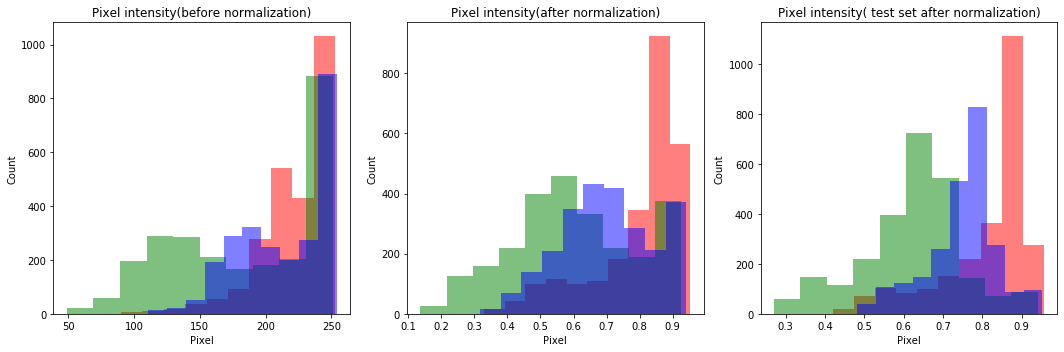

In [ ]:
# To visualize the training intensity before and after normalization

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

x_input
#Pixel intensity of all the data before normalization
axs[0].hist(x_input[1,:,:,0].flatten(), bins=10, lw=0, color='r', alpha=0.5);
axs[0].hist(x_input[1,:,:,1].flatten(), bins=10, lw=0, color='g', alpha=0.5);
axs[0].hist(x_input[1,:,:,2].flatten(), bins=10, lw=0, color='b', alpha=0.5);
axs[0].set_title('Pixel intensity(before normalization)')
axs[0].set_xlabel('Pixel')
axs[0].set_ylabel('Count')

#Pixel intensity of training data after normalization
axs[1].hist(X_train[1,:,:,0].flatten(), bins=10, lw=0, color='r', alpha=0.5);
axs[1].hist(X_train[1,:,:,1].flatten(), bins=10, lw=0, color='g', alpha=0.5);
axs[1].hist(X_train[1,:,:,2].flatten(), bins=10, lw=0, color='b', alpha=0.5);
axs[1].set_title('Pixel intensity(after normalization)')
axs[1].set_xlabel('Pixel')
axs[1].set_ylabel('Count')

#Pixel intensity of test data after normalization
axs[2].hist(X_test[1,:,:,0].flatten(), bins=10, lw=0, color='r', alpha=0.5);
axs[2].hist(X_test[1,:,:,1].flatten(), bins=10, lw=0, color='g', alpha=0.5);
axs[2].hist(X_test[1,:,:,2].flatten(), bins=10, lw=0, color='b', alpha=0.5);
axs[2].set_title('Pixel intensity( test set after normalization)')
axs[2].set_xlabel('Pixel')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

**MODEL1: CONVOLUTIONAL NEURAL NETWORK I**

In [ ]:
#Initializing the model:
model_1= Sequential()
model_1.add(Conv2D(filters = 32,
                 kernel_size=(3,3),
                 input_shape=(50,50,3),
                 activation='relu'))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(units=512, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

# To compile the model
lr = 0.01 # learning rate
epochs = 30
model_1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',  metrics=['accuracy'])

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3872)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [ ]:
# To set a random seed for reproducibility and to train the model
seed = 42

callback = EarlyStopping(monitor='loss', patience=4)

np.random.seed(seed)

history = model_1.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      callbacks=[callback],
                      batch_size=64)


print(len(history.history['loss']))

Epoch 1/30
65/65 [==============================] - 5s 65ms/step - loss: 0.6436 - accuracy: 0.6541 - val_loss: 0.6289 - val_accuracy: 0.6489
Epoch 2/30
65/65 [==============================] - 4s 60ms/step - loss: 0.5789 - accuracy: 0.7082 - val_loss: 0.5435 - val_accuracy: 0.7253
Epoch 3/30
65/65 [==============================] - 4s 60ms/step - loss: 0.5630 - accuracy: 0.7197 - val_loss: 0.5987 - val_accuracy: 0.6929
Epoch 4/30
65/65 [==============================] - 4s 60ms/step - loss: 0.5425 - accuracy: 0.7375 - val_loss: 0.5532 - val_accuracy: 0.7282
Epoch 5/30
65/65 [==============================] - 4s 62ms/step - loss: 0.5545 - accuracy: 0.7252 - val_loss: 0.5989 - val_accuracy: 0.6770
Epoch 6/30
65/65 [==============================] - 4s 61ms/step - loss: 0.5494 - accuracy: 0.7349 - val_loss: 0.5555 - val_accuracy: 0.7203
Epoch 7/30
65/65 [==============================] - 4s 60ms/step - loss: 0.5238 - accuracy: 0.7570 - val_loss: 0.5372 - val_accuracy: 0.7340
Epoch 8/30
65

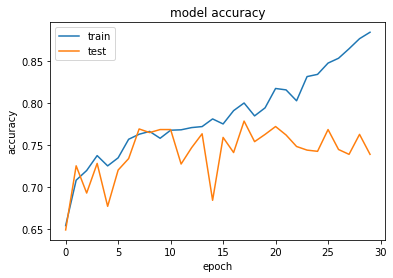

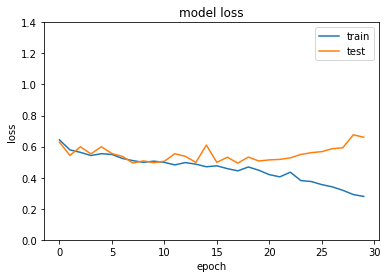

In [ ]:
# To summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.ylim([0,1])
# To summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0,1.4])
plt.show()

In [ ]:
# Evaluate model accuracy
score = model_1.evaluate(X_test, y_test, verbose=0)
print('Model_1: CNNI accuracy:', score[1], '\n')

# Make predictions and convert probabilities to binary predictions
preds = model_1.predict(X_test)
preds1 = np.round(preds)

# Print classification report
print(classification_report(y_test, preds1))

Model_1: CNNI accuracy: 0.7390050292015076 

44/44 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       686
           1       0.75      0.72      0.74       701

    accuracy                           0.74      1387
   macro avg       0.74      0.74      0.74      1387
weighted avg       0.74      0.74      0.74      1387



In [ ]:
#To evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, preds1)
conf_matrix

array([[521, 165],
       [197, 504]], dtype=int64)

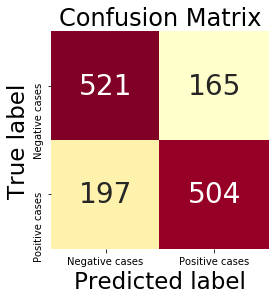

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, preds1)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 28})

plt.xlabel('Predicted label', fontsize=23)
plt.ylabel('True label', fontsize=23)
plt.title('Confusion Matrix', fontsize=24)

plt.show()

44/44 [==============================] - 0s 7ms/step


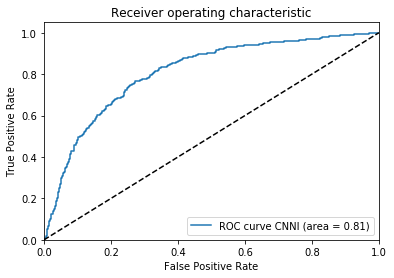

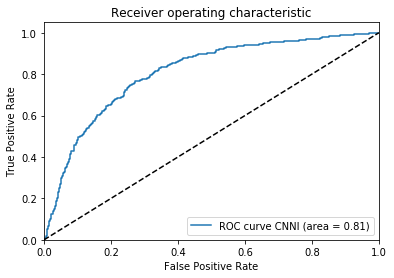

In [ ]:
from sklearn.metrics import roc_curve, auc

y_score = model_1.predict(X_test) # get the prediction probabilities

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
for i in range(num_classes):
    fpr1[i], tpr1[i], _ = roc_curve(y_test, preds)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr1[i], tpr1[i], label='ROC curve CNNI (area = %0.2f)' % roc_auc1[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

44/44 [==============================] - 0s 7ms/step
AUPRC1: 0.7793772110950611


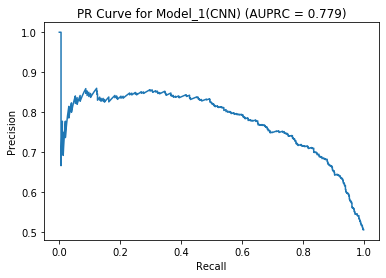

In [ ]:
# To determine the probabilities for positive class
y_scores = model_1.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc = average_precision_score(y_test, y_scores)
print('AUPRC1:', auprc)

# To Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Model_1(CNN) (AUPRC = {:.3f})'.format(auprc))
plt.show()

**MODEL 2: CONVOLUTIONAL NEURAL NETWORKS II**

In [ ]:
x_resized = np.zeros((x_input.shape[0], 75, 75, 3))
for i in range(x_input.shape[0]):
    x_resized[i] = resize(x_input[i], (75, 75,3), anti_aliasing=True)

print('x_input dimension: x_resized= {}'.format(x_resized.shape))

x_input dimension: x_resized= (5547, 75, 75, 3)


The preserve_range is set to False by default, which automatically scales the pixels of the images between 0 t0 1 (5. Image data types and what they mean — skimage 0.21.0rc1.dev0 documentation, no date)

In [ ]:
#To split the data with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(x_resized,
                                                    y_target, test_size=0.20,
                                                    random_state=0)

In [ ]:
#To create the model:
model_2= Sequential()
model_2.add(Conv2D(filters = 32,
                 kernel_size=(4,4),
                 input_shape=(75,75,3),
                 activation='relu'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(units=512, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
# To compile the model
lr = 0.01 # learning rate
epochs = 25
model_2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',  metrics=['accuracy'])



print(model_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        1568      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 9248)              0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [ ]:
callback = EarlyStopping(monitor='loss', patience=4)

In [ ]:
#Fitting the model
history = model_2.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      callbacks=[callback],
                      batch_size=64)


print(len(history.history['loss']))

Epoch 1/25
70/70 [==============================] - 10s 135ms/step - loss: 0.6950 - accuracy: 0.5909 - val_loss: 0.6158 - val_accuracy: 0.6468
Epoch 2/25
70/70 [==============================] - 9s 128ms/step - loss: 0.5868 - accuracy: 0.7009 - val_loss: 0.5426 - val_accuracy: 0.7369
Epoch 3/25
70/70 [==============================] - 9s 131ms/step - loss: 0.5658 - accuracy: 0.7144 - val_loss: 0.5788 - val_accuracy: 0.7153
Epoch 4/25
70/70 [==============================] - 9s 135ms/step - loss: 0.5603 - accuracy: 0.7223 - val_loss: 0.5211 - val_accuracy: 0.7604
Epoch 5/25
70/70 [==============================] - 9s 131ms/step - loss: 0.5608 - accuracy: 0.7199 - val_loss: 0.5637 - val_accuracy: 0.7234
Epoch 6/25
70/70 [==============================] - 10s 136ms/step - loss: 0.5288 - accuracy: 0.7480 - val_loss: 0.5357 - val_accuracy: 0.7505
Epoch 7/25
70/70 [==============================] - 10s 136ms/step - loss: 0.5468 - accuracy: 0.7334 - val_loss: 0.5116 - val_accuracy: 0.7622
Epo

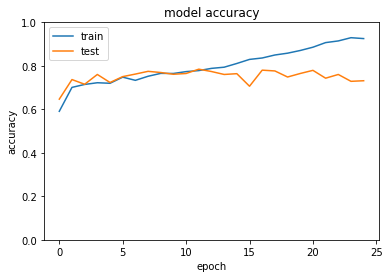

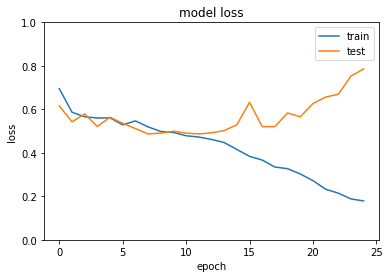

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0, 1])  # Set y-axis limits
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 1])  # Set y-axis limits
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
#To evaluate the model accuracy:
score = model_2.evaluate(X_test, y_test, verbose=0)
print('model_2: CNN accuracy:', score[1], '\n')

preds = model_2.predict(X_test)
preds1 = np.round(preds)
print(preds.shape) # which means the predictions return in one-hot encoding format
print(preds.shape)
print(y_test.shape)
print(classification_report(y_test, preds1))

model_2: CNN accuracy: 0.73153156042099 

35/35 [==============================] - 1s 14ms/step
(1110, 1)
(1110, 1)
(1110,)
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       542
           1       0.75      0.72      0.73       568

    accuracy                           0.73      1110
   macro avg       0.73      0.73      0.73      1110
weighted avg       0.73      0.73      0.73      1110



In [ ]:
#To evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, preds1)
conf_matrix

array([[403, 139],
       [159, 409]], dtype=int64)

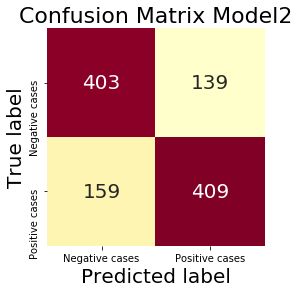

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, preds1)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 20})

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.title('Confusion Matrix Model2', fontsize=22)

plt.show()

35/35 [==============================] - 1s 14ms/step


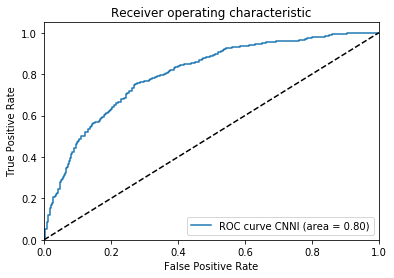

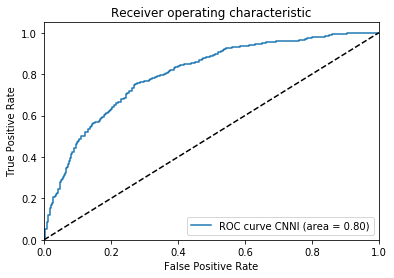

In [ ]:
# To plot the ROC

y_score = model_2.predict(X_test) # get the prediction probabilities

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(num_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_test, preds)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr2[i], tpr2[i], label='ROC curve CNNI (area = %0.2f)' % roc_auc2[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

35/35 [==============================] - 0s 14ms/step
AUPRC for Positive Class: 0.7908419293396383


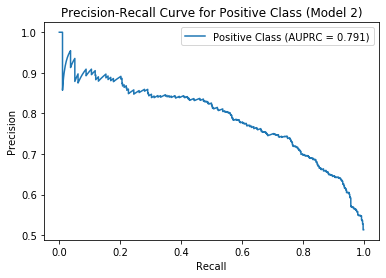

In [ ]:
# To plot the Precision-Recall Curve

y_scores = model_2.predict(X_test) # predicts the probability for the test data
y_test = y_test.reshape((-1, 1)) # reshape the label to match y_scores
precisions_pos, recalls_pos, thresholds_pos = precision_recall_curve(y_test, y_scores)
auprc2b = average_precision_score(y_test, y_scores)
print('AUPRC for Positive Class:', auprc2b)
plt.plot(recalls_pos, precisions_pos, label='Positive Class (AUPRC = {:.3f})'.format(auprc2b))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Positive Class (Model 2)')
plt.legend();

**MODEL 3: CONVOLUTIONAL NEURAL NETWORKS III**


In [ ]:
#To split the data with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(x_input, y_target, test_size=0.20, random_state=0)
#Normalization
X_train = X_train / 255.0
print('X Shape:', X_train.shape)

X_test = X_test / 255.0
print('X Shape:', X_test.shape)

X Shape: (4437, 50, 50, 3)
X Shape: (1110, 50, 50, 3)


In [ ]:
# Create the model
model_3 = Sequential()
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3))) # first layer : convolution
model_3.add(MaxPooling2D(pool_size=(3, 3))) # second layer : pooling (reduce the size of the image per 3)
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(3, 3)))
model_3.add(Dropout(0.25)) #Drop out with rate 0.25
model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5)) #Drop out with rate 0.5
model_3.add(Dense(units=1, activation='sigmoid')) # output layer to give value between 0 and 1
model_3.summary()
epochs3 = 40

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [ ]:
model_3.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
                metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)

history = model_3.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs3,
                    callbacks=[callback])


print(len(history.history['loss']))

Epoch 1/40
139/139 [==============================] - 3s 19ms/step - loss: 0.6749 - accuracy: 0.5767 - val_loss: 0.5824 - val_accuracy: 0.7036
Epoch 2/40
139/139 [==============================] - 2s 18ms/step - loss: 0.6075 - accuracy: 0.6883 - val_loss: 0.6793 - val_accuracy: 0.5820
Epoch 3/40
139/139 [==============================] - 2s 18ms/step - loss: 0.5753 - accuracy: 0.7235 - val_loss: 0.6424 - val_accuracy: 0.6676
Epoch 4/40
139/139 [==============================] - 2s 18ms/step - loss: 0.5603 - accuracy: 0.7295 - val_loss: 0.5291 - val_accuracy: 0.7495
Epoch 5/40
139/139 [==============================] - 3s 18ms/step - loss: 0.5541 - accuracy: 0.7368 - val_loss: 0.5541 - val_accuracy: 0.7306
Epoch 6/40
139/139 [==============================] - 3s 18ms/step - loss: 0.5496 - accuracy: 0.7372 - val_loss: 0.5575 - val_accuracy: 0.7207
Epoch 7/40
139/139 [==============================] - 3s 18ms/step - loss: 0.5389 - accuracy: 0.7453 - val_loss: 0.5033 - val_accuracy: 0.7577

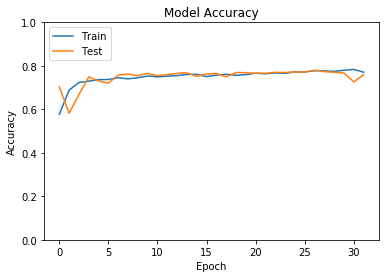

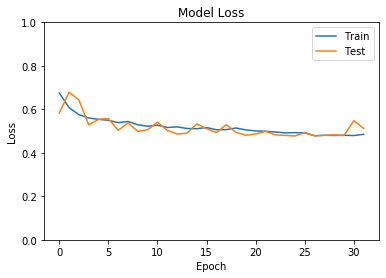

In [ ]:
# visualize the results
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
#To compute the Classification report
score = model_3.evaluate(X_test, y_test, verbose=0)
print('\nKeras MODEL3 - accuracy:', score[1], '\n')

preds = model_3.predict(X_test)
preds1 = np.round(preds).astype(int)

print(preds.shape)
print(preds.shape)
print(y_test.shape)
print(classification_report(y_test, preds1))
conf_matx = confusion_matrix(y_test, preds1)


Keras MODEL3 - accuracy: 0.7603603601455688 

35/35 [==============================] - 0s 5ms/step
(1110, 1)
(1110, 1)
(1110,)
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       542
           1       0.71      0.90      0.79       568

    accuracy                           0.76      1110
   macro avg       0.78      0.76      0.75      1110
weighted avg       0.78      0.76      0.76      1110



In [ ]:
def build_model(hp):
    model_3= Sequential()
    model_3.add(Conv2D(hp.Choice('filters', [8, 16, 32]),
    kernel_size=(3, 3),
    input_shape=(50, 50, 3),
    activation='relu'))
    model_3.add(MaxPooling2D(pool_size=(3, 3))) # second layer : pooling (reduce the size of the image per 3)
    model_3.add(Conv2D(32, (3, 3), activation='relu'))
    model_3.add(MaxPooling2D(pool_size=(3, 3)))
    model_3.add(Dropout(0.25))
    model_3.add(Flatten())
    model_3.add(Dense(64, activation='relu'))
    model_3.add(Dropout(0.5))
    model_3.add(Dense(units=1, activation='sigmoid')) # num_classes = 2
    # To compile the model
    lr = hp.Choice('learning_rate', [0.1, 0.01, 0.001]) # learning rate
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    epochs = 30
    model_3.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
                metrics=['accuracy'])
    return model_3

In [ ]:
#Setting the parameters for the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5);

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [ ]:
# Step 3: start the search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.7666666507720947

Best val_accuracy So Far: 0.7756756544113159
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner.results_summary())

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
filters: 16
learning_rate: 0.01
optimizer: sgd
Score: 0.7801801562309265

Trial 1 summary
Hyperparameters:
filters: 8
learning_rate: 0.1
optimizer: rmsprop
Score: 0.7747747898101807

Trial 0 summary
Hyperparameters:
filters: 32
learning_rate: 0.01
optimizer: sgd
Score: 0.7702702879905701

Trial 2 summary
Hyperparameters:
filters: 8
learning_rate: 0.1
optimizer: sgd
Score: 0.7702702879905701

Trial 3 summary
Hyperparameters:
filters: 16
learning_rate: 0.1
optimizer: rmsprop
Score: 0.76846843957901
None


In [ ]:
# To get the best hperparamters
best_hp = tuner.get_best_hyperparameters()[0]
best_filters = best_hp.get('filters')
best_learning_rate = best_hp.get('learning_rate')
print('Best Filters: {}'.format(best_filters))
print('Best Learning Rate: {}'.format(best_learning_rate))

Best Filters: 8
Best Learning Rate: 0.01


In [ ]:
#Train-Test Split
X_train, X_test, y_train, y_test =train_test_split(x_input,
                                                   y_target, test_size = 0.15, random_state = 5)

#Normalization
X_train = X_train / 255.0
print('X Shape:', X_train.shape)

X_test = X_test / 255.0
print('X Shape:', X_test.shape)

X Shape: (4714, 50, 50, 3)
X Shape: (833, 50, 50, 3)


In [ ]:
#Instantiating the augmented images
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.2,
        height_shift_range=0.3,
        vertical_flip=True,
        horizontal_flip=False,
        zoom_range=0.5,
        fill_mode='wrap')

In [ ]:
# Define custom callback to stop training at desired validation accuracy
class samsoncallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.805:
            print('\nStopping training as accuracy has reached 80.5%')
            self.model.stop_training = True

# Train model with callbacks
history = model_3.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=200,
                      validation_data=(X_test, y_test), verbose=2, shuffle=True,
                      callbacks=[checkpoint_callback, samsoncallback()])


Epoch 1/200
70/70 - 3s - loss: 0.4464 - accuracy: 0.7922 - val_loss: 0.4527 - val_accuracy: 0.7982 - 3s/epoch - 45ms/step
Epoch 2/200
70/70 - 3s - loss: 0.4361 - accuracy: 0.8023 - val_loss: 0.4554 - val_accuracy: 0.8000 - 3s/epoch - 45ms/step
Epoch 3/200
70/70 - 3s - loss: 0.4350 - accuracy: 0.7974 - val_loss: 0.4533 - val_accuracy: 0.8000 - 3s/epoch - 44ms/step
Epoch 4/200
70/70 - 3s - loss: 0.4424 - accuracy: 0.7960 - val_loss: 0.4463 - val_accuracy: 0.7946 - 3s/epoch - 44ms/step
Epoch 5/200
70/70 - 3s - loss: 0.4396 - accuracy: 0.8010 - val_loss: 0.4459 - val_accuracy: 0.7991 - 3s/epoch - 45ms/step
Epoch 6/200
70/70 - 3s - loss: 0.4484 - accuracy: 0.7942 - val_loss: 0.4986 - val_accuracy: 0.7667 - 3s/epoch - 44ms/step
Epoch 7/200
70/70 - 3s - loss: 0.4457 - accuracy: 0.7938 - val_loss: 0.4687 - val_accuracy: 0.7874 - 3s/epoch - 45ms/step
Epoch 8/200
70/70 - 3s - loss: 0.4362 - accuracy: 0.7978 - val_loss: 0.4585 - val_accuracy: 0.7829 - 3s/epoch - 44ms/step
Epoch 9/200
70/70 - 3s -

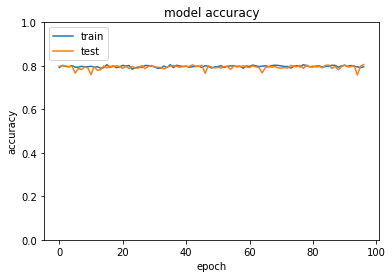

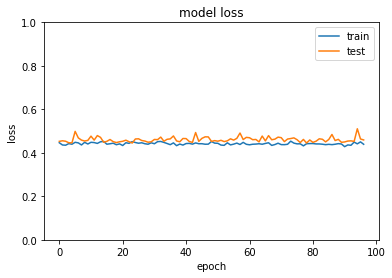

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0, 1])
plt.show()


In [ ]:
score = model_3.evaluate(X_test, y_test, verbose=0)
print('\nKeras - accuracy:', score[1], '\n')

y_preds = model_3.predict(X_test)
y_preds1= np.round(y_preds)
print(y_preds1.shape) # which means the predictions return in one-hot encoding format
y_preds = np.argmax(y_preds1, axis=1)
print(y_preds.shape)
print(classification_report(y_test, y_preds1))
conf_matx = confusion_matrix(y_test, y_preds1)


Keras - accuracy: 0.8063063025474548 

35/35 [==============================] - 0s 5ms/step
(1110, 1)
(1110,)
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       566
           1       0.79      0.83      0.81       544

    accuracy                           0.81      1110
   macro avg       0.81      0.81      0.81      1110
weighted avg       0.81      0.81      0.81      1110



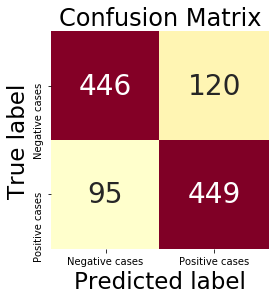

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_preds1)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 28})

plt.xlabel('Predicted label', fontsize=23)
plt.ylabel('True label', fontsize=23)
plt.title('Confusion Matrix', fontsize=24)

plt.show()

35/35 [==============================] - 0s 5ms/step


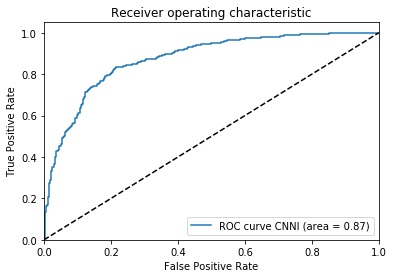

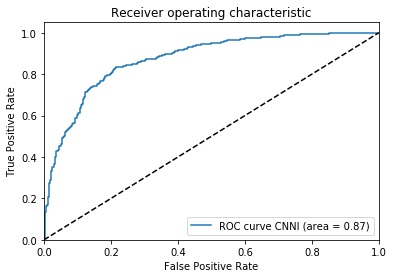

In [ ]:
y_score = model_3.predict(X_test) # get the prediction probabilities

fpr3 = dict()
tpr3 = dict()
roc_auc3 = dict()
for i in range(num_classes):
    fpr3[i], tpr3[i], _ = roc_curve(y_test, y_preds)
    roc_auc3[i] = auc(fpr3[i], tpr3[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr3[i], tpr3[i], label='ROC curve CNNI (area = %0.2f)' % roc_auc3[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

44/44 [==============================] - 0s 4ms/step
AUPRC: 0.8602126843280227


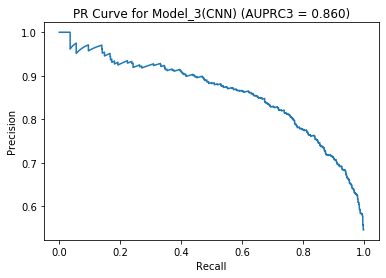

In [ ]:
# Get predicted probabilities for positive class
y_scores = model_3.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc3 = average_precision_score(y_test, y_scores)
print('AUPRC:', auprc3)

# Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Model_3(CNN) (AUPRC3 = {:.3f})'.format(auprc3))
plt.show()

## MODEL 4: PRETRAINED MODEL(MobileNetV2)

In [ ]:
#Instantiating the model
base_model = MobileNetV2(weights='imagenet',
                        input_shape=(50, 50, 3),
                        include_top=False)
base_model.trainable = False
inputs = Input(shape=(50, 50, 3))
x = base_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(128, activation='relu')(x1) # extra dense layer with 128 units and relu activation
x2 = Dropout(0.2)(x2) # Add a dropout layer with a rate of 0.2
outputs = Dense(1, activation='sigmoid')(x2)
model_4 = Model(inputs, outputs)
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 128)               163968    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129 

In [ ]:
#To split the data with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(x_input, y_target, test_size=0.20, random_state=42)

In [ ]:
# Scale pixel values to range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
model_4.fit(X_train,
          y_train,
          validation_data=(X_test,y_test),
          epochs=30)

Epoch 1/30
139/139 [==============================] - 8s 41ms/step - loss: 0.5982 - accuracy: 0.7000 - val_loss: 0.5330 - val_accuracy: 0.7459
Epoch 2/30
139/139 [==============================] - 5s 35ms/step - loss: 0.5050 - accuracy: 0.7550 - val_loss: 0.5491 - val_accuracy: 0.7369
Epoch 3/30
139/139 [==============================] - 5s 36ms/step - loss: 0.4742 - accuracy: 0.7807 - val_loss: 0.5440 - val_accuracy: 0.7523
Epoch 4/30
139/139 [==============================] - 5s 35ms/step - loss: 0.4337 - accuracy: 0.7978 - val_loss: 0.5774 - val_accuracy: 0.7261
Epoch 5/30
139/139 [==============================] - 5s 35ms/step - loss: 0.4046 - accuracy: 0.8213 - val_loss: 0.5602 - val_accuracy: 0.7432
Epoch 6/30
139/139 [==============================] - 5s 35ms/step - loss: 0.3659 - accuracy: 0.8413 - val_loss: 0.5722 - val_accuracy: 0.7505
Epoch 7/30
139/139 [==============================] - 5s 35ms/step - loss: 0.3318 - accuracy: 0.8582 - val_loss: 0.5793 - val_accuracy: 0.7468

In [ ]:
#Instantiating the augmented images
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.2,
        height_shift_range=0.3,
        vertical_flip=True,
        horizontal_flip=False,
        zoom_range=0.5,
        fill_mode='wrap')

In [ ]:
#Fitting with the augmented images
model_4.fit(datagen.flow(X_train, y_train, batch_size=64),
          validation_data=(X_test, y_test),
          epochs=25)

Epoch 1/25
70/70 [==============================] - 6s 71ms/step - loss: 0.7285 - accuracy: 0.6863 - val_loss: 0.6064 - val_accuracy: 0.6811
Epoch 2/25
70/70 [==============================] - 5s 73ms/step - loss: 0.5744 - accuracy: 0.7081 - val_loss: 0.5748 - val_accuracy: 0.7261
Epoch 3/25
70/70 [==============================] - 5s 75ms/step - loss: 0.5688 - accuracy: 0.7192 - val_loss: 0.5620 - val_accuracy: 0.7216
Epoch 4/25
70/70 [==============================] - 5s 74ms/step - loss: 0.5531 - accuracy: 0.7235 - val_loss: 0.5463 - val_accuracy: 0.7405
Epoch 5/25
70/70 [==============================] - 5s 74ms/step - loss: 0.5586 - accuracy: 0.7176 - val_loss: 0.5531 - val_accuracy: 0.7261
Epoch 6/25
70/70 [==============================] - 5s 77ms/step - loss: 0.5551 - accuracy: 0.7230 - val_loss: 0.5578 - val_accuracy: 0.7162
Epoch 7/25
70/70 [==============================] - 5s 73ms/step - loss: 0.5486 - accuracy: 0.7280 - val_loss: 0.5436 - val_accuracy: 0.7378
Epoch 8/25
70

In [ ]:
#To evaluate model_4 accuracy:
score = model_4.evaluate(X_test, y_test, verbose=0)
print('Model_4: MobileNetV2 accuracy:', score[1], '\n')

preds = best_model.predict(X_test)
preds1 = np.round(preds)
print(preds.shape)
print(preds.shape)
print(y_test.shape)
print(classification_report(y_test, preds1))

Model_4: MobileNetV2 accuracy: 0.7387387156486511 

35/35 [==============================] - 0s 4ms/step
(1110, 1)
(1110, 1)
(1110,)
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       566
           1       0.83      0.64      0.73       544

    accuracy                           0.76      1110
   macro avg       0.78      0.76      0.76      1110
weighted avg       0.78      0.76      0.76      1110



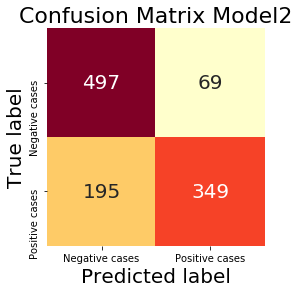

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, preds1)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 20})

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.title('Confusion Matrix Model2', fontsize=22)

plt.show()

35/35 [==============================] - 1s 28ms/step


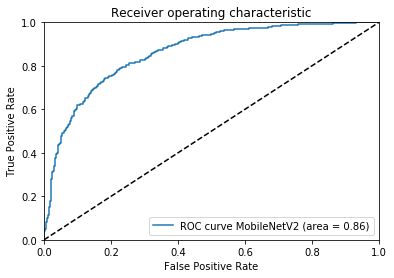

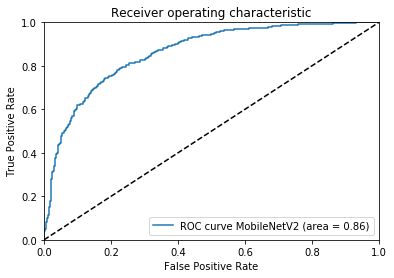

In [ ]:
# To plot the ROC curve
from sklearn.metrics import roc_curve, auc

y_score = model_4.predict(X_test) # get the prediction probabilities

fpr4 = dict()
tpr4 = dict()
roc_auc4 = dict()
for i in range(num_classes):
    fpr4[i], tpr4[i], _ = roc_curve(y_test, preds)
    roc_auc4[i] = auc(fpr4[i], tpr4[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr4[i], tpr4[i], label='ROC curve MobileNetV2 (area = %0.2f)' % roc_auc4[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.00]) # set limit for y axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

35/35 [==============================] - 1s 28ms/step
AUPRC4: 0.7793772110950611


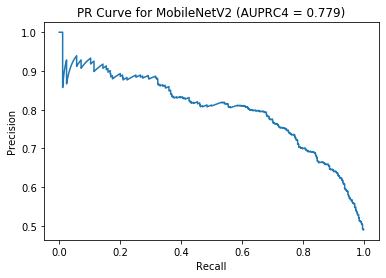

In [ ]:
#To plot the PR curve
# Determine the probabilities for positive class
y_scores = model_4.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# To calculate area under the PRC
auprc4 = average_precision_score(y_test, y_scores)
print('AUPRC4:', auprc)

# Plot the PR curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for MobileNetV2 (AUPRC4 = {:.3f})'.format(auprc))
plt.show()

**MODEL 5 MULTILAYER PERCEPTRON**

In [ ]:
#To split the data with 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x_input, y_target, test_size=0.25, random_state=0)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

(4160, 7500)

In [ ]:
# create model
model_5 = Sequential()
model_5.add(Dense(12, input_dim=7500, activation='relu')) #
model_5.add(Dropout(0.2))
model_5.add(Dense(8, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(1, activation='sigmoid'))

In [ ]:
model_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 12)                90012     
                                                                 
 dropout_10 (Dropout)        (None, 12)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 104       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
 dropout_12 (Dropout)        (None, 1)                 0         
                                                                 
 dropout_13 (Dropout)        (None, 1)                

In [ ]:
# Compile model
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_5.fit(X_train,
          y_train,
          validation_data=(X_test,y_test),
          epochs=25)

Epoch 1/25
130/130 [==============================] - 1s 3ms/step - loss: 0.9522 - accuracy: 0.6440 - val_loss: 0.6092 - val_accuracy: 0.7311
Epoch 2/25
130/130 [==============================] - 0s 2ms/step - loss: 0.7257 - accuracy: 0.6702 - val_loss: 0.6301 - val_accuracy: 0.6748
Epoch 3/25
130/130 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.6846 - val_loss: 0.5900 - val_accuracy: 0.7022
Epoch 4/25
130/130 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.6925 - val_loss: 0.5503 - val_accuracy: 0.7484
Epoch 5/25
130/130 [==============================] - 0s 2ms/step - loss: 0.6054 - accuracy: 0.7087 - val_loss: 0.5837 - val_accuracy: 0.7275
Epoch 6/25
130/130 [==============================] - 0s 2ms/step - loss: 0.5593 - accuracy: 0.7358 - val_loss: 0.5820 - val_accuracy: 0.7628
Epoch 7/25
130/130 [==============================] - 0s 2ms/step - loss: 0.5473 - accuracy: 0.7450 - val_loss: 0.5278 - val_accuracy: 0.7541
Epoch 

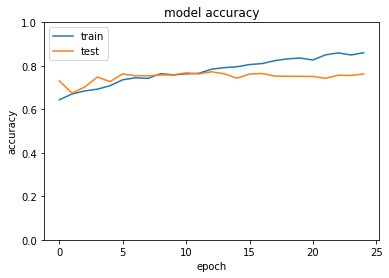

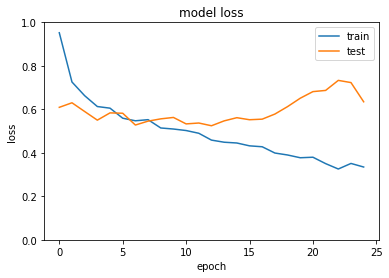

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0,1])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0,1])
plt.show()

In [ ]:
#To evaluate the model accuracy:
score = model_5.evaluate(X_test, y_test, verbose=1)
print('model_5: CNN accuracy:', score[1], '\n')

preds = model_5.predict(X_test)
print(preds.shape) # which means the predictions return in one-hot encoding format
preds1 = np.round(preds)
print(preds1.shape)
print(y_test.shape)
print(classification_report(y_test, preds1))

44/44 [==============================] - 0s 1ms/step - loss: 0.6347 - accuracy: 0.7628
model_5: CNN accuracy: 0.7627974152565002 

44/44 [==============================] - 0s 951us/step
(1387, 1)
(1387, 1)
(1387,)
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       686
           1       0.76      0.78      0.77       701

    accuracy                           0.76      1387
   macro avg       0.76      0.76      0.76      1387
weighted avg       0.76      0.76      0.76      1387



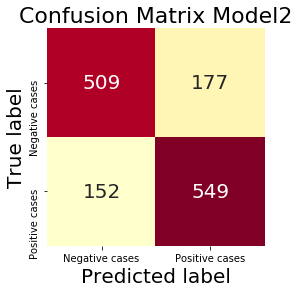

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, preds1)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 20})

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.title('Confusion Matrix Model2', fontsize=22)

plt.show()

44/44 [==============================] - 0s 905us/step


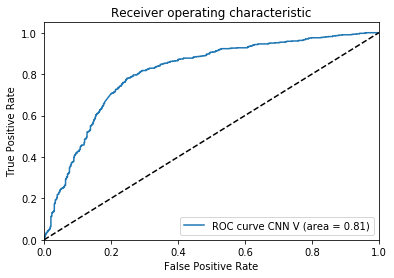

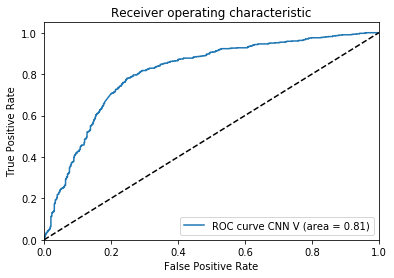

In [ ]:
# To plot the ROC

y_score = model_5.predict(X_test) # get the prediction probabilities

fpr5 = dict()
tpr5 = dict()
roc_auc5 = dict()
for i in range(num_classes):
    fpr5[i], tpr5[i], _ = roc_curve(y_test, preds)
    roc_auc5[i] = auc(fpr5[i], tpr5[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr5[i], tpr5[i],
             label='ROC curve CNN V (area = %0.2f)' % roc_auc5[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

44/44 [==============================] - 0s 951us/step
AUPRC for Positive Class: 0.7908419293396383


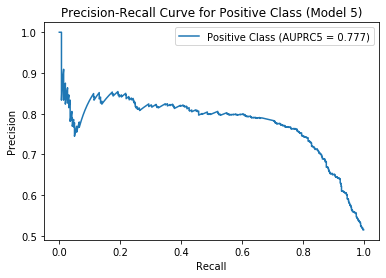

In [ ]:
y_scores = model_5.predict(X_test)
y_test = y_test.reshape((-1, 1))
precisions_pos, recalls_pos, thresholds_pos = precision_recall_curve(y_test, y_scores)
auprc5b = average_precision_score(y_test, y_scores)
print('AUPRC for Positive Class:', auprc2b)
plt.plot(recalls_pos, precisions_pos, label='Positive Class (AUPRC5 = {:.3f})'.format(auprc5b))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Positive Class (Model 5)')
plt.legend()
plt.show()

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) # n_splits: num of folds
cvscores = [] # define this empty list to add the scores in
for train, test in kfold.split(X_train, y_train):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=7500, activation='relu'))
    model_5.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model_5.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 71.59%
accuracy: 71.16%
accuracy: 70.51%
accuracy: 75.34%
accuracy: 71.74%
accuracy: 71.88%
accuracy: 72.89%
accuracy: 70.80%
accuracy: 70.73%
accuracy: 72.31%
71.90% (+/- 1.35%)


## MODEL 6: Support Vector Machines

In [ ]:
# To split the data with 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x_input, y_target, test_size=0.25, random_state=0)

In [ ]:
#Reshaping the 4D  TO 2D to suit the classical model
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
#This prints the shape of the train and test set
X_train.shape, X_test.shape

((4160, 7500), (1387, 7500))

In [ ]:
X_train[20]

array([0.91505801, 1.30544227, 1.28541194, ..., 0.81530901, 0.88100434,
       0.89142242])

In [ ]:
# train the SVM classifier:

model = SVC(kernel='rbf')
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# This predict the test set labels
y_preds = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       686
           1       0.81      0.67      0.73       701

    accuracy                           0.75      1387
   macro avg       0.76      0.75      0.75      1387
weighted avg       0.76      0.75      0.75      1387



In [ ]:
#To set the hyperparameter grid
grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf','poly']}

In [ ]:
random_search = RandomizedSearchCV(clf, param_distributions=grid, n_iter=5)

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='linear', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=5, n_jobs=None,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best hyperparameters:  {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1}
Best score:  0.7663461538461538


In [ ]:
#To choose the best tuned performance
best_svm= svm.SVC(kernel=random_search.best_params_['kernel'],
                   C=random_search.best_params_['C'],
                   gamma=random_search.best_params_['gamma'])
best_svm.fit(X_train, y_train)
y_preds = best_svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       686
           1       0.79      0.78      0.79       701

    accuracy                           0.79      1387
   macro avg       0.79      0.79      0.79      1387
weighted avg       0.79      0.79      0.79      1387



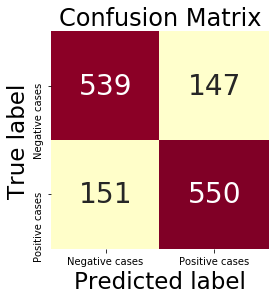

In [ ]:
# To plot the confusion matrix
mat = confusion_matrix(y_test, y_preds)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative cases', 'Positive cases'],
            yticklabels=['Negative cases', 'Positive cases'],
            cmap='YlOrRd', annot_kws={"fontsize": 28})

plt.xlabel('Predicted label', fontsize=23)
plt.ylabel('True label', fontsize=23)
plt.title('Confusion Matrix', fontsize=24)

plt.show()

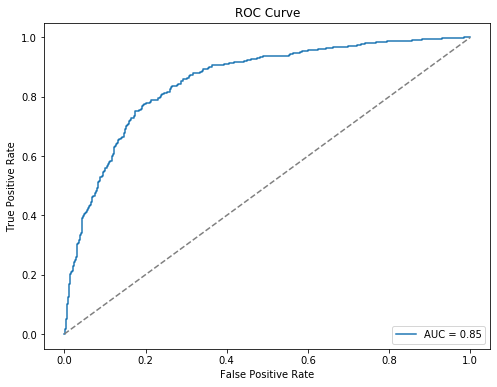

In [ ]:
# To predict probabilities for the test set
y_pred_prob = best_svm.decision_function(X_test)

# To calculate the ROC curve and the AUC score
fpr6, tpr6, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# To plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr6, tpr6, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

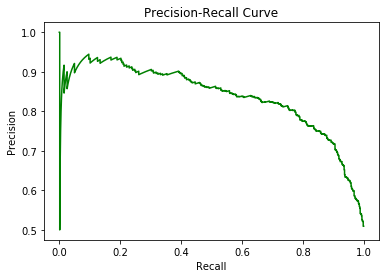

In [ ]:
# To get the precision and recall values for the test set
precision, recall, _ = precision_recall_curve(y_test, best_clf.decision_function(X_test))

# To plot the PR curve
plt.plot(recall, precision, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Discussion and Evaluation

The summary of the performance of the six models are shown in the table below:
![image.png](attachment:image.png)



The performance of the models was tested on the following metric:

**Accuracy:** This is the proportion or ratio in percentage of the true positive results of cancer cases (true positive and true negative inclusive). Model 3 (CNN3) is apparently the best performing model of the 6 models, with a test accuracy of 81% and a training accuracy of 80%. SVM model came second with a test accuracy of 79%.

**Precision:** Precision is the characteristic of the positive precision made by the model. It is mathematically the number of the true positive result divided by the total number of positive predictions (true positives and false positives). The pretrained model (MobileNetV2) had the highest precision score.

**Recall:** This is the percentage of correct positive results made from all the positive predictions that could have been made. It is mathematically the ratio of the true positive and the sum of the true positives and the false negatives.

**F1 Score:** It is a machine learning evaluation metric that combines the precision and the recall score of an algorithm. CNN3 has the most impressive F1 score.

**Area under the curve:** The AUC is the measure of the ability of a model to distinguish between the classes. CNN3 has the most impressive area under the curve score for both ROC and the PRC


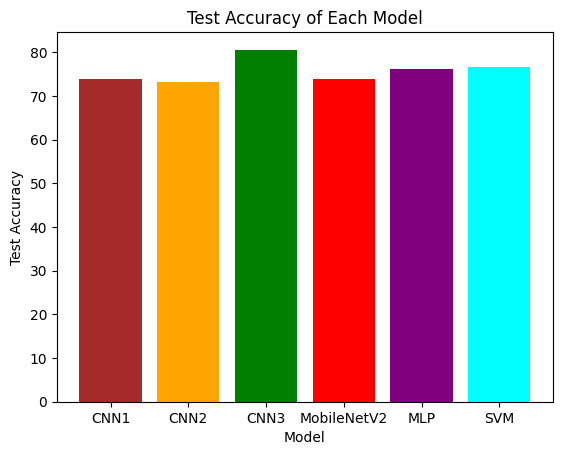

In [ ]:
#To plot the Test Accuracy of each model
import matplotlib.pyplot as plt

models = ['CNN1', 'CNN2', 'CNN3', 'MobileNetV2', 'MLP', 'SVM']
test_accuracy = [73.9, 73.15, 80.63, 73.87, 76.28, 76.63]
colors = ['brown', 'orange',
          'green', 'red', 'purple', 'cyan'] #Defining the colours

plt.bar(models, test_accuracy, color=colors)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Each Model');


### Conclusion:

This study explored six machine learning models consisting of variants of CNN models, MobileNetV2 which is a based on a pretrained architecture, in the classification of breast cancer. Of all the models CNN(CNN3) exhibited the most promising and impressive performance which is inline with previous research. CNN3 achieved a relatively high test accuracy of 81% and also performed well across all the metrics which it is evaluated on better than the rest of the models. MobileNetV2 AND SVM also had considerable good performance.
This study will be of great impact in the field of medicine and will help in the early and accurate detection off breast cancer.
There are however some areas of improvement which could help these models perform much better. This include the tuning of more hyperparameters, more augmentation of data. There is also a possibility of high performance with availability of more training data

### References

Image data types and what they mean — skimage 0.21.0rc1.dev0 documentation (no date). Available at: https://scikit-image.org/docs/dev/user_guide/data_types.html.

Alkhatib, M.Q., Al-Saad, M., Aburaed, N., Almansoori, S., Zabalza, J., Marshall, S. and Al-Ahmad, H., 2023. Tri-CNN: a three branch model for hyperspectral image classification. Remote Sensing, 15(2), p.316.

Chen, L., Li, S., Bai, Q., Yang, J., Jiang, S. and Miao, Y., 2021. Review of image classification algorithms based on convolutional neural networks. Remote Sensing, 13(22), p.4712.

Hafiz, A.M., Bhat, R.A. and Hassaballah, M., 2023. Image classification using convolutional neural network tree ensembles. Multimedia Tools and Applications, 82(5), pp.6867-6884.

Jin, K. (2022). Handwritten digit recognition based on classical machine learning methods. 2022 3rd International Conference on Electronic Communication and Artificial Intelligence (IWECAI).

Neural Network Diagram Complete Guide | EdrawMax (no date). Available at: https://www.edrawsoft.com/article/neural-network-diagram.html.

Wongsuphasawat, K. et al. (2018) “Visualizing Dataflow Graphs of Deep Learning Models in TensorFlow,” IEEE Transactions on Visualization and Computer Graphics, 24(1), pp. 1–12. Available at: https://doi.org/10.1109/tvcg.2017.2744878.

Yamashita, R., Nishio, M., Do, R.K.G. and Togashi, K., 2018. Convolutional neural networks: an overview and application in radiology. Insights into imaging, 9, pp.611-629.





